# Autolaparo
It can be seen that
- Left / Right, zoom-in / zoom-out motions correlate a little with camera motion extraction
- Individual sequences contain multiple labels and are not well isolated
- Impossible to use for evaluation
- Should poll motion sequences from heichole / cholec80 instead, using mean or similar

- for out purposes, one should learn on non-static data, ie data where running average exceeds certain threshold

In [32]:
import sys
sys.path.append("../..")
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from utils.io import load_yaml

server = "local"
server = load_yaml("../../config/servers.yml")[server]

increment = 5

database = server["database"]["location"]
prefix = "autolaparo_single_frames/AutoLaparo_Task2"
motion_pickle = f"23_02_24_pre_processed_frame_increment_{increment}_frames_between_clips_1_log.pkl"
label_pickle = "laparoscope_motion_label.csv"

# from readme
motion_dict = {
    0: "Static",
    1: "Up",
    2: "Down",
    3: "Left",
    4: "Right",
    5: "Zoom-in",
    6: "Zoom-out",
}

motion_df = pd.read_pickle(os.path.join(database, prefix, motion_pickle))
motion_df = motion_df.dropna().reset_index(drop=True)
motion_df["duv"] = motion_df["duv"].apply(lambda x: np.array(x))

# motion_df = motion_df.sort_values(by=["vid", "frame"]).reset_index(drop=True)
label_df = pd.read_csv(os.path.join(database, prefix, label_pickle))
label_df["Clip"] = label_df["Clip"].apply(lambda x: x - 1)

print(label_df)
print(motion_df)

Reading file from ../../config/servers.yml
     Clip  Label  Phase
0       0      5      2
1       1      6      2
2       2      2      2
3       3      2      2
4       4      3      2
..    ...    ...    ...
295   295      2      4
296   296      2      4
297   297      2      4
298   298      0      2
299   299      0      4

[300 rows x 3 columns]
        folder           file  vid frame  \
0        vid_0    frame_0.npy    0     0   
1        vid_0    frame_1.npy    0     1   
2        vid_0    frame_2.npy    0     2   
3        vid_0    frame_3.npy    0     3   
4        vid_0    frame_4.npy    0     4   
...        ...            ...  ...   ...   
73495  vid_299  frame_240.npy  299   240   
73496  vid_299  frame_241.npy  299   241   
73497  vid_299  frame_242.npy  299   242   
73498  vid_299  frame_243.npy  299   243   
73499  vid_299  frame_244.npy  299   244   

                                                     duv   duv_mpd  
0      [[0.9502004981040955, -2.277380704879760

        folder           file  vid frame   duv_0_0   duv_0_1   duv_1_0  \
0        vid_0    frame_0.npy    0     0  0.950200 -2.277381  0.153858   
1        vid_0    frame_1.npy    0     1  0.873137 -1.774108 -0.058371   
2        vid_0    frame_2.npy    0     2 -0.209653 -1.858151 -0.358575   
3        vid_0    frame_3.npy    0     3 -0.907219 -1.724021 -0.732986   
4        vid_0    frame_4.npy    0     4 -1.312820 -1.617454 -1.300955   
...        ...            ...  ...   ...       ...       ...       ...   
73495  vid_299  frame_240.npy  299   240 -4.061273 -2.049564 -2.044876   
73496  vid_299  frame_241.npy  299   241 -4.069256 -1.870202 -2.078970   
73497  vid_299  frame_242.npy  299   242 -4.209295 -1.758451 -2.280341   
73498  vid_299  frame_243.npy  299   243 -4.311522 -1.644651 -2.428076   
73499  vid_299  frame_244.npy  299   244 -4.048018 -1.259987 -2.503620   

        duv_1_1   duv_2_0   duv_2_1   duv_3_0   duv_3_1 classes  
0     -2.228692  0.938909 -2.506219  5.753414

<AxesSubplot: >

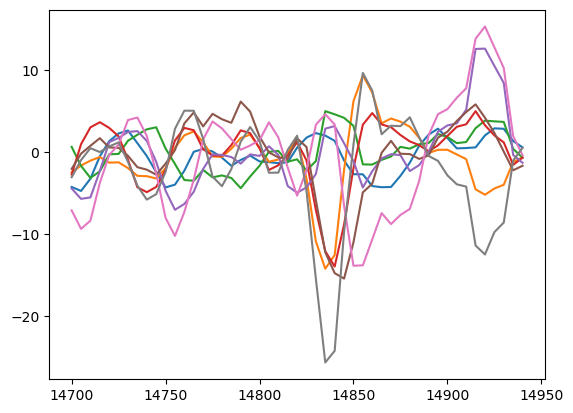

In [70]:
# de-couple duv
motion_df["duv"] = motion_df["duv"].apply(lambda x: x.flatten())
df_split = pd.DataFrame(motion_df["duv"].to_list(), columns=[f"duv_{i}_{j}" for i in range(4) for j in range(2)])
df_split = pd.concat([motion_df[["folder", "file", "vid", "frame"]], df_split], axis=1)

# print(df_split)

def angle(duv_i_0, duv_i_1, duv_i_length):
    ang = np.arccos(duv_i_1 / duv_i_length)
    if -duv_i_0 >= 0:
        return ang
    if -duv_i_0 < 0:
        return 2*np.pi - ang 

def ang_to_lr_ud(duv_0_0_ang, duv_1_0_ang, duv_2_0_ang, duv_3_0_ang):
    duv_0_quarter = np.floor((duv_0_0_ang + np.pi / 4.) / (np.pi / 2))
    duv_1_quarter = np.floor((duv_1_0_ang + np.pi / 4.) / (np.pi / 2))
    duv_2_quarter = np.floor((duv_2_0_ang + np.pi / 4.) / (np.pi / 2))
    duv_3_quarter = np.floor((duv_3_0_ang + np.pi / 4.) / (np.pi / 2))

    if \
        duv_0_quarter == 0 and \
        duv_1_quarter == 0 and \
        duv_2_quarter == 0 and \
        duv_3_quarter == 0:
        return "right"
    if \
        duv_0_quarter == 2 and \
        duv_1_quarter == 2 and \
        duv_2_quarter == 2 and \
        duv_3_quarter == 2:
        return "left"
    if \
        duv_0_quarter == 1 and \
        duv_1_quarter == 1 and \
        duv_2_quarter == 1 and \
        duv_3_quarter == 1:
        return "up"
    if \
        duv_0_quarter == 3 and \
        duv_1_quarter == 3 and \
        duv_2_quarter == 3 and \
        duv_3_quarter == 3:
        return "down"
    return "unknown"

def ang_to_io_lr(duv_0_0_ang, duv_1_0_ang, duv_2_0_ang, duv_3_0_ang):
    duv_0_quarter = np.floor(duv_0_0_ang / (np.pi / 2))
    duv_1_quarter = np.floor(duv_1_0_ang / (np.pi / 2))
    duv_2_quarter = np.floor(duv_2_0_ang / (np.pi / 2))
    duv_3_quarter = np.floor(duv_3_0_ang / (np.pi / 2))

    if \
        duv_0_quarter == 1 and \
        duv_1_quarter == 0 and \
        duv_2_quarter == 3 and \
        duv_3_quarter == 2:
        return "zoom-out"
    if \
        duv_0_quarter == 3 and \
        duv_1_quarter == 2 and \
        duv_2_quarter == 1 and \
        duv_3_quarter == 0:
        return "zoom-in"
    if \
        duv_0_quarter == 0 and \
        duv_1_quarter == 3 and \
        duv_2_quarter == 2 and \
        duv_3_quarter == 1:
        return "rotate_right"
    if \
        duv_0_quarter == 2 and \
        duv_1_quarter == 1 and \
        duv_2_quarter == 0 and \
        duv_3_quarter == 3:
        return "rotate_left"
    return "unknown"
    
def classifier(row, motion_threadhold: float = 10):
    duv_0_0 = row["duv_0_0"]
    duv_0_1 = row["duv_0_1"]
    duv_1_0 = row["duv_1_0"]
    duv_1_1 = row["duv_1_1"]
    duv_2_0 = row["duv_2_0"]
    duv_2_1 = row["duv_2_1"]
    duv_3_0 = row["duv_3_0"]
    duv_3_1 = row["duv_3_1"]

    duv_0_length = np.sqrt(duv_0_0 ** 2 + duv_0_1 ** 2)
    duv_1_length = np.sqrt(duv_1_0 ** 2 + duv_1_1 ** 2)
    duv_2_length = np.sqrt(duv_2_0 ** 2 + duv_2_1 ** 2)
    duv_3_length = np.sqrt(duv_3_0 ** 2 + duv_3_1 ** 2)

    # amplitude below threshold is considered static
    if (
        duv_0_length < motion_threadhold and
        duv_1_length < motion_threadhold and
        duv_2_length < motion_threadhold and
        duv_3_length < motion_threadhold
    ):
        return "static"

    # compute angle between 0 unit vector
    duv_0_0_ang = angle(duv_0_0, duv_0_1, duv_0_length)
    duv_1_0_ang = angle(duv_1_0, duv_1_1, duv_1_length)
    duv_2_0_ang = angle(duv_2_0, duv_2_1, duv_2_length)
    duv_3_0_ang = angle(duv_3_0, duv_3_1, duv_3_length)

    # classify
    case = ang_to_lr_ud(duv_0_0_ang, duv_1_0_ang, duv_2_0_ang, duv_3_0_ang)
    if case != "unknown":
        return case
    return ang_to_io_lr(duv_0_0_ang, duv_1_0_ang, duv_2_0_ang, duv_3_0_ang)
   

df_split[["duv_0_0", "duv_0_1", "duv_1_0", "duv_1_1", "duv_2_0", "duv_2_1", "duv_3_0", "duv_3_1"]] = df_split[
    ["duv_0_0", "duv_0_1", "duv_1_0", "duv_1_1", "duv_2_0", "duv_2_1", "duv_3_0", "duv_3_1"]
].rolling(20, min_periods=1).mean()

# df_split = df_split.rolling(20, min_periods=1).mean()

df_split["classes"] = df_split.apply(classifier, axis=1)
print(df_split)
print(df_split.classes.unique())
# print(df_split[df_split["classes"] == "left"])

# rolling average per video
# 25 fps at 5 frame increment
# df_split.groupby("vid")
id = 60
print("autolaparo class: {}".format(motion_dict[label_df.iloc[id]["Label"]]))
df_split_id = df_split[df_split["vid"] == id]
df_split_id = df_split_id[::increment]
# df_split_id = df_split_id.rolling(20, min_periods=1).mean()
df_split_id.duv_0_0.plot()
df_split_id.duv_0_1.plot()
df_split_id.duv_1_0.plot()
df_split_id.duv_1_1.plot()
df_split_id.duv_2_0.plot()
df_split_id.duv_2_1.plot()
df_split_id.duv_3_0.plot()
df_split_id.duv_3_1.plot()


# Analyze Motion

In [ ]:
motion_df = motion_df[::increment]
print(motion_df.shape)

for key in motion_dict:
    print(f"Analyzing {motion_dict[key]} motion")
    clips = label_df[label_df["Label"] == key].Clip.values
    frames = motion_df[motion_df["vid"].isin(clips)].reset_index(drop=True)
    
    duv0 = np.array(frames["duv"].apply(lambda x: x[0]).to_list())
    duv1 = np.array(frames["duv"].apply(lambda x: x[1]).to_list())
    duv2 = np.array(frames["duv"].apply(lambda x: x[2]).to_list())
    duv3 = np.array(frames["duv"].apply(lambda x: x[3]).to_list())

    print(f"duv0: {duv0.mean(axis=0)} pm {duv0.std(axis=0)}")
    print(f"duv1: {duv1.mean(axis=0)} pm {duv1.std(axis=0)}")
    print(f"duv2: {duv2.mean(axis=0)} pm {duv2.std(axis=0)}")
    print(f"duv3: {duv3.mean(axis=0)} pm {duv3.std(axis=0)}")

    plt.scatter(duv0[:, 0], duv0[:, 1], label="duv0")
    plt.scatter(duv1[:, 0], duv1[:, 1], label="duv1")
    plt.scatter(duv2[:, 0], duv2[:, 1], label="duv2")
    plt.scatter(duv3[:, 0], duv3[:, 1], label="duv3")
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.legend()
    plt.show()


# Motion as Sequence

In [ ]:
horizon = 2

def scalar_product(a: np.ndarray) -> np.ndarray:
    return np.array([np.dot(a[i], a[i+1]) / (np.linalg.norm(a[i]) * np.linalg.norm(a[i+1])) for i in range(len(a) - 1)])

def no_sign_change(a: np.ndarray, horizon: int=10) -> np.ndarray:
    no_change = [True]*(len(a)-horizon)
    for i in range(len(a) - horizon):
        for j in range(horizon):
            no_change[i] = no_change[i] and np.sign(a[i]) == np.sign(a[i+j])
    return np.array(no_change)
        

def no_sign_changes(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    return np.array([a[i] and b[i] and c[i] and d[i] for i in range(len(a))])

for key in motion_dict:
    print(f"Analyzing {motion_dict[key]} motion")
    clips = label_df[label_df["Label"] == key].Clip.values
    frames = motion_df[motion_df["vid"].isin(clips)].reset_index(drop=True)
    
    duv0 = np.array(frames["duv"].apply(lambda x: x[0]).to_list())
    duv1 = np.array(frames["duv"].apply(lambda x: x[1]).to_list())
    duv2 = np.array(frames["duv"].apply(lambda x: x[2]).to_list())
    duv3 = np.array(frames["duv"].apply(lambda x: x[3]).to_list())

    # compute scalar product of previous and current motion vectors
    duv0_no_sign_change = no_sign_change(scalar_product(duv0), horizon)
    duv1_no_sign_change = no_sign_change(scalar_product(duv1), horizon)
    duv2_no_sign_change = no_sign_change(scalar_product(duv2), horizon)
    duv3_no_sign_change = no_sign_change(scalar_product(duv3), horizon)

    no_changes = no_sign_changes(duv0_no_sign_change, duv1_no_sign_change, duv2_no_sign_change, duv3_no_sign_change)

    # get duvs where no sign change occured
    duv0 = duv0[:-horizon, :][np.argwhere(no_changes)].squeeze()
    duv1 = duv1[:-horizon, :][np.argwhere(no_changes)].squeeze()
    duv2 = duv2[:-horizon, :][np.argwhere(no_changes)].squeeze()
    duv3 = duv3[:-horizon, :][np.argwhere(no_changes)].squeeze()

    plt.scatter(duv0[:, 0], duv0[:, 1], label="duv0")
    plt.scatter(duv1[:, 0], duv1[:, 1], label="duv1")
    plt.scatter(duv2[:, 0], duv2[:, 1], label="duv2")
    plt.scatter(duv3[:, 0], duv3[:, 1], label="duv3")
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.legend()
    plt.show()

    
    


In [ ]:
for key in motion_dict:
    print(f"Analyzing {motion_dict[key]} motion")
    clips = label_df[label_df["Label"] == key].Clip.values
    frames = motion_df[motion_df["vid"].isin(clips)].reset_index(drop=True)
    
    duv0 = np.array(frames["duv"].apply(lambda x: x[0]).to_list())
    duv1 = np.array(frames["duv"].apply(lambda x: x[1]).to_list())
    duv2 = np.array(frames["duv"].apply(lambda x: x[2]).to_list())
    duv3 = np.array(frames["duv"].apply(lambda x: x[3]).to_list())

    # duv0 = duv0[np.linalg.norm(duv0, axis=1) > 40]
    # duv1 = duv1[np.linalg.norm(duv1, axis=1) > 40]
    # duv2 = duv2[np.linalg.norm(duv2, axis=1) > 40]
    # duv3 = duv3[np.linalg.norm(duv3, axis=1) > 40]

    duv0 = duv0.sum(axis=0)
    duv1 = duv1.sum(axis=0)
    duv2 = duv2.sum(axis=0)
    duv3 = duv3.sum(axis=0)

    max_norm = 0
    norms = [
        np.linalg.norm(duv0),
        np.linalg.norm(duv1),
        np.linalg.norm(duv2),
        np.linalg.norm(duv3),
    ]
    for norm in norms:
        if norm > max_norm:
            max_norm = norm

    duv0 = duv0 / max_norm
    duv1 = duv1 / max_norm
    duv2 = duv2 / max_norm
    duv3 = duv3 / max_norm

    plt.scatter(duv0[1], duv0[0], label="duv0")
    plt.scatter(duv1[1], duv1[0], label="duv1")
    plt.scatter(duv2[1], duv2[0], label="duv2")
    plt.scatter(duv3[1], duv3[0], label="duv3")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.legend()
    plt.show()


In [74]:
import torch
import numpy as np
from kornia import tensor_to_image, image_to_tensor
from kornia.geometry import resize, warp_perspective
import PIL
from IPython.display import Image, display, clear_output, TextDisplayObject

from utils import four_point_homography_to_matrix, image_edges
from utils.viz import create_blend_from_four_point_homography

shape = [240, 320]
display_shape = [480, 640]
motion_id = 3

# motion_dict = {
#     0: "Static",
#     1: "Up",
#     2: "Down",
#     3: "Left",
#     4: "Right",
#     5: "Zoom-in",
#     6: "Zoom-out",
# }

# unique_motion_df = motion_df[motion_df["vid"].isin(label_df[label_df["Label"] == motion_id].Clip.values)].reset_index(drop=True)
unique_motion_df = df_split[df_split["vid"].isin(label_df[label_df["Label"] == motion_id].Clip.values)].reset_index(drop=True)

# write a video using opencv
import cv2
import os

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(f'/tmp/output_{motion_id}.avi',fourcc, 10.0, (1280, 480))

cnt = 0
for idx, row in unique_motion_df.iterrows():
    img = np.load(os.path.join(database, prefix, row.folder, row.file))
    wrp = np.load(os.path.join(database, prefix, unique_motion_df.iloc[idx + increment].folder, unique_motion_df.iloc[idx + increment].file))
    img, wrp = resize(image_to_tensor(img, keepdim=False).float()/255., shape), resize(image_to_tensor(wrp, keepdim=False).float()/255., shape)

    # duv = torch.tensor(row.duv).unsqueeze(0)
    duv = torch.tensor([
        [row.duv_0_0, row.duv_0_1],
        [row.duv_1_0, row.duv_1_1],
        [row.duv_2_0, row.duv_2_1],
        [row.duv_3_0, row.duv_3_1],
    ]).unsqueeze(0)

    # h = four_point_homography_to_matrix(image_edges(img), -duv)
    # wrp_est = warp_perspective(img, h, dsize=img.shape[-2:])
    # wrp = (tensor_to_image(wrp, keepdim=False)*255.).astype(np.uint8)
    # wrp_est = (tensor_to_image(wrp_est, keepdim=False)*255.).astype(np.uint8)
    # concat = np.concatenate([wrp, wrp_est], axis=1)
    
    blend = create_blend_from_four_point_homography(wrp, img, -duv)
    blend = resize(blend, display_shape)
    img = resize(img, display_shape)
    blend = (tensor_to_image(blend, keepdim=False)*255.).astype(np.uint8)
    img = (tensor_to_image(img, keepdim=False)*255.).astype(np.uint8)
    concat = np.concatenate([blend, img[...,::-1]], axis=1)

    # display(PIL.Image.fromarray(concat))
    # display(TextDisplayObject("AutoLaparo label: {}, refined label: {}".format(motion_dict[label_df.iloc[row.vid]["Label"]], row.classes)).data)
    # clear_output(wait=True)

    text = "AutoLaparo label: {}, our re-label: {}".format(motion_dict[label_df.iloc[row.vid]["Label"]], row.classes)
    concat = cv2.putText(concat.copy(), text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    out.write(concat)
    if cnt >500:
        break
    cnt+=1
out.release()

    # input()
